In [1]:
import girder_client as gc
from pprint import pprint
import sys, os
from IPython.display import Image

dsaGC = gc.GirderClient(apiUrl="http://candygram.neurology.emory.edu:8080/api/v1")

In [13]:
##going to use some of the special tcga endpoints to make my life a little easier
## This gets a list of all available cancer types along with the ID of the cohort which I'll then use
## to grab some slide images
TCGACohortList = dsaGC.get('/tcga/cohort')
cohortData = {}
for x in  TCGACohortList['data']:
    cohortData[x['lowerName']] = { '_id': x['_id'], 'lowerName': x['lowerName']}

In [19]:
## Let's get the gbm cohort and then grab the first image
gbmImageSet = dsaGC.get('/tcga/cohort/%s/images?limit=10' % cohortData['gbm']['_id'])
print len( gbmImageSet['data'] )  ## Great I got data on 10 slides...

10


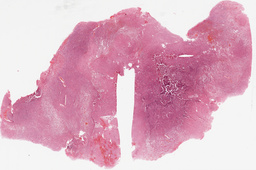

In [22]:
### Example of where I download a single image but before that I also render it in the viewer
# this will grab the first TCGA GBM image I found
sampleItemToGrab = gbmImageSet['data'][4]
imgWidth = 256

curImageMacroUrl = '/item/%s/tiles/thumbnail?width=%s' % (sampleItemToGrab['_id'],imgWidth)
curImage = dsaGC.get(curImageMacroUrl,  jsonResp=False)        


with open("./sampleImage.jpg","wb") as fp:
    fp.write(curImage.content)

Image(curImage.content)

In [ ]:
class LinePrinter():
    """
    Print things to stdout on one line dynamically
    """
    def __init__(self,data):
        sys.stdout.write("\r\x1b[K"+data.__str__())
        sys.stdout.flush()

In [ ]:
## get the cases for the cohort
dxSlidesFound = totalSlidesFound = collsProcessed = slidesOnDisk = cohortsProcessed = 0

for cohort,data in cohortData.iteritems():
    slideList = dsaGC.get('/tcga/cohort/%s/images?&limit=9000' % data['_id'])
    ## I only want to get images that end in DX1 for now
    cohortsProcessed+=1 
    dxSlidesForCohort = []
    
    for sld in slideList['data']:
        totalSlidesFound +=1
        
        if 'DX1' in sld['tcga']['barcode']:
            dxSlidesFound +=1
            dxSlidesForCohort.append(sld)
        else:
            pass
        cohortData[cohort]['dxCaseList'] = dxSlidesForCohort
        
    ## This returns a list of slides, but also has a ton of properties that can get confusing for non experts
    #print len(slideList.data)
    LinePrinter( "Processed Cohort %d/%d: %d slides, and found %d slides" % (cohortsProcessed, len(cohortData),totalSlidesFound, dxSlidesFound))

In [ ]:
cohortData['gbm']['dxCaseList'][0:10]

In [ ]:
print len( cohortData['gbm']['dxCaseList'])

macroImageRootPath = '/home/dagutman/Documents/tcga_imgs/macro_thumbnails/'

imgWidth = 256
slidesProcessed = slidesDownloaded = 0


for cohort,data in cohortData.iteritems():
    try:
        slideSet = data['dxCaseList']
    except:
        print "Cant find case list??"
        print data
        
    for sld in slideSet:
        slidesProcessed +=1 

        ##filename will have the word macro.thumb.width
        outputPath = os.path.join(macroImageRootPath,cohort)
        if not os.path.isdir(outputPath):
            os.makedirs(outputPath)
        outputFile = os.path.join(outputPath,sld['name']+'.macro.thumb.%d.jpeg' % imgWidth)

        if not os.path.isfile(outputFile):
            curImageMacroUrl = '/item/%s/tiles/thumbnail?width=%s' % (sld['_id'],imgWidth)
            curImage = dsaGC.get(curImageMacroUrl,  jsonResp=False)        
            with open(outputFile,"wb") as fp:
                fp.write(curImage.content)
            slidesDownloaded +=1
        
        LinePrinter("You have processed %d files and just downloaded %d" % (slidesProcessed,slidesDownloaded))

In [ ]:
## Copy Data to Training/Testing/Validation Directory
import shutil
import random
import math
import glob
## Dare I use a HARD LINK??

def copyDataCohort( imgList, baseTargetDir, trainProportion=0.75,validationProportion=0.05,testingProportion=0.2,emptyTargetDir = True):
    random.shuffle(imgList)
    
    train = []
    test = []
    validate = []
    for i in imgList:
        rnd = random.random()
        
        if rnd < trainProportion:
            train.append(i)
        elif (rnd >= trainProportion  and rnd < (trainProportion + validationProportion) ):
            validate.append(i)
        else:
            test.append(i)
    
    ## Now copy the training/testing and validation data
    for i in train:
        td = os.path.join(baseTargetDir,'train')
        if not os.path.isdir(td):
            os.makedirs(td)
        shutil.copy2(i,td)
    ## Now copy the images print len(test),len(train),len(validate)

In [ ]:
# blcaImgSet = glob.glob(macroImageRootPath+'blca/*.jpeg')

# tgtDir = '/home/dagutman/Documents/tcga_imgs/dataSetsForDL/'

# copyDataCohort(blcaImgSet,tgtDir+'blca')